This Notebook was inspired by the Model Maker Tutorial available in the [Tensorflow Documentation](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection)

# Importing external libraries

In [ ]:
import os
import json
import math
import shutil
import pprint
import numpy as np
from PIL import Image, ImageDraw
import cv2

# Extracting and Preparing the Data

In [ ]:
# Downloading the images and labels file
! wget -q https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/raw_image_data.zip
! wget -q https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/labels.txt
! wget -q https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/background_images.zip
! unzip -qq ./raw_image_data.zip
! unzip -qq ./background_images.zip
! rm -f ./raw_image_data.zip 

In [ ]:
RAW_DATA_PATH = './raw_image_data/'
LABELS_FILE = './labels.txt'

In [ ]:
LABELS = {}
with open(LABELS_FILE, 'r') as f:
  labels = f.readlines()
  labels = [label.replace('\n', '') for label in labels]
  for i, label in enumerate(labels):
    random_color_rgb = tuple(np.random.choice(range(256), size=3))
    LABELS[label] = { 
                      'id': i, 
                      'bb_color_rgb': random_color_rgb, 
                      'pictures': {}, 
                      'total_pictures': 0
                    }
pprint.pprint(LABELS)

{'blue_pens': {'bb_color_rgb': (69, 239, 233),
               'id': 4,
               'pictures': {},
               'total_pictures': 0},
 'card_deck': {'bb_color_rgb': (5, 239, 29),
               'id': 3,
               'pictures': {},
               'total_pictures': 0},
 'coke_soda': {'bb_color_rgb': (139, 250, 74),
               'id': 2,
               'pictures': {},
               'total_pictures': 0},
 'guarana_soda': {'bb_color_rgb': (55, 198, 181),
                  'id': 1,
                  'pictures': {},
                  'total_pictures': 0},
 'post_it': {'bb_color_rgb': (105, 78, 174),
             'id': 0,
             'pictures': {},
             'total_pictures': 0}}


In [ ]:
AMT_CLASSES = len(LABELS)
print('Total number of classes:', AMT_CLASSES)

Total number of classes: 5


In [ ]:
BACKGROUND_IMAGES = os.listdir('./background_images')

In [ ]:
TOT_BACKGROUND_IMAGES = len(BACKGROUND_IMAGES)

In [ ]:
# Inspecting the bounding boxes file
bounding_boxes = json.load(open(RAW_DATA_PATH + 'bounding_boxes.labels'))
#print(json.dumps(bounding_boxes, indent=2)[0:600])

In [ ]:
# Flipping the bounding_boxes dictionary as so as we can more easily identify 
# all pictures that relate to a specific class
for image in bounding_boxes["boundingBoxes"]:
  for obj in bounding_boxes["boundingBoxes"][image]:
    LABELS[obj['label']]['pictures'][RAW_DATA_PATH + image] = \
        {
            'x_left': obj['x'], 
            'y_bottom': obj['y'], 
            'bb_width': obj['width'], 
            'bb_height': obj['height']
         }
    LABELS[obj['label']]['total_pictures'] += 1

In [ ]:
print('Total pictures for each class:')
for label in LABELS:
  print(label + ', ' + str(LABELS[label]['total_pictures']))

Total pictures for each class:
post_it, 273
guarana_soda, 283
coke_soda, 276
card_deck, 306
blue_pens, 293


In [ ]:
#pprint.pprint(LABELS['post_it'])

In [ ]:
# Create a folder structure for training
if not os.path.exists('CURATED_DATA'):
  for split in ['TRAINING', 'VALIDATION', 'TEST']:
    os.makedirs(f'CURATED_DATA/IMAGES/{split}')
  os.makedirs(f'CURATED_DATA/BACKGROUND_IMAGES/')

In [ ]:
# Function used for troubleshooting only, draws an image with an individual 
# bounding box
def draw_image_w_ind_bb(im, x_left, y_top, x_right, y_bottom, bb_color):
  draw = ImageDraw.Draw(im)
  draw.rectangle(
        (x_left, y_top, x_right, y_bottom),
        outline = bb_color, 
        width = 5 # line width
  )
  display(im)

In [ ]:
# Crops or resizes a labelled image from the LABELS dictionary
def preprocess_labeled_image(class_name, image_path_and_name, dim_square = None, resize = False): 
  im = Image.open(image_path_and_name)
  im_width, im_height = im.size

  bb_width = LABELS[class_name]['pictures'][image_path_and_name]['bb_width']
  bb_height = LABELS[class_name]['pictures'][image_path_and_name]['bb_height']
  bb_color = LABELS[class_name]['bb_color_rgb']

  x_left = LABELS[class_name]['pictures'][image_path_and_name]['x_left']
  x_right = x_left + bb_width
  y_bottom = LABELS[class_name]['pictures'][image_path_and_name]['y_bottom']
  y_top =  y_bottom + bb_height

  if(not resize):

    if(dim_square is None):
      dim_square = min(im_width, im_height)

    left_boundary = 0
    right_boundary = im_width
    bottom_boundary = 0
    top_boundary = im_height
    
    # Crops the image
    if(dim_square < im_height and dim_square < im_width):
      left_boundary = (im_width - dim_square) / 2
      top_boundary = (im_height - dim_square) / 2 + dim_square
      right_boundary = (im_width - dim_square) / 2 + dim_square
      bottom_boundary = (im_height - dim_square) / 2
    elif(dim_square < im_width):
      left_boundary = (im_width - dim_square) / 2
      top_boundary = dim_square
      right_boundary = (im_width - dim_square) / 2 + dim_square
      bottom_boundary = 0
    elif(dim_square < im_height):
      left_boundary = 0
      top_boundary = (im_height - dim_square) / 2 + dim_square
      right_boundary = dim_square
      bottom_boundary = (im_height - dim_square) / 2

    im_cropped = im.crop((left_boundary, bottom_boundary, 
                          right_boundary, top_boundary))

    # Redefines the bounding boxes coordinates
    
    # This return represents that we will exclude images where the bounding box
    # lies out of the cropping boundaries
    if(x_left >= right_boundary or x_right <= left_boundary \
      or y_bottom >= top_boundary or y_top <= bottom_boundary):
      return -1, -1, -1, -1, -1, True

    if(x_left <= left_boundary):
      x_left = 0
    else:
      x_left = x_left - left_boundary

    if(x_right >= right_boundary):
      x_right = dim_square
    else:
      x_right = x_right - left_boundary
    
    if(y_bottom <= bottom_boundary):
      y_bottom = 0
    else:
      y_bottom = y_bottom - bottom_boundary
    
    if(y_top >= top_boundary):
      y_top = top_boundary
    else:
      y_top = y_top - bottom_boundary

    bb_width = x_right - x_left
    bb_height = y_top - y_bottom

    return im_cropped, bb_height, bb_width, x_left, y_bottom, False

  else:
    new_size = (dim_square, dim_square)
    im_resized = im.resize(new_size)

    bb_height = bb_height * dim_square / im_height
    bb_width = bb_width * dim_square / im_width

    x_left = x_left * dim_square / im_width
    x_right = x_right * dim_square / im_width
    y_top = y_top * dim_square / im_height
    y_bottom = y_bottom * dim_square / im_height

    # used for troubleshooting
    #draw_image_w_ind_bb(im_resized, x_left, y_top, x_right, y_bottom, bb_color)

    return im_resized, bb_height, bb_width, x_left, y_bottom, False

In [ ]:
#preprocess_labeled_image('post_it', './raw_image_data/unknown.39n07pl2.ingestion-645f8b4d4f-p2vmk.jpg', DIM_SQUARE, resize=True)

In [ ]:
# Preprocesses all labeled images
def curate_dataset(class_name, image_names, train_size, val_size):
  for i, image_path_and_name in enumerate(image_names):
        # Gets the image file name
        image_name = image_path_and_name.replace('./raw_image_data/', '')
        
        # Splits into train, val and test
        if i < train_size:
            split = 'TRAINING'
        elif i < train_size + val_size:
            split = 'VALIDATION'
        else:
            split = 'TEST'

        # Updates split identifier
        LABELS[class_name]['pictures'][image_path_and_name]['type'] = split
        
        # Preprocesses the image and saves it into the curated folder
        source_image_path = image_path_and_name
        target_image_folder = f'CURATED_DATA/IMAGES/{split}'
        curated_image_path_and_name = './' + target_image_folder + '/' + image_name

        im_cropped, bb_height, bb_width, x_left, y_bottom, exclude_image = preprocess_labeled_image(class_name, source_image_path, dim_square=DIM_SQUARE, resize=RESIZE_FLG)
        
        if(exclude_image == True):
          LABELS[class_name]['pictures'].pop(image_path_and_name)
        else:
          im_cropped.save(curated_image_path_and_name)

          # Updates image key as so as it shows its location in the curated folder
          LABELS[class_name]['pictures'][curated_image_path_and_name] =  LABELS[class_name]['pictures'].pop(image_path_and_name)

          # Updates the image attributes
          LABELS[class_name]['pictures'][curated_image_path_and_name]['bb_height'] = bb_height
          LABELS[class_name]['pictures'][curated_image_path_and_name]['bb_width'] = bb_width
          LABELS[class_name]['pictures'][curated_image_path_and_name]['x_left'] = x_left
          LABELS[class_name]['pictures'][curated_image_path_and_name]['y_bottom'] = y_bottom

In [ ]:
DIM_SQUARE = 320
RESIZE_FLG = True

In [ ]:
train_pct = 70
test_pct = 30 # 30% of the images that would go to validation will actually be used to run tests

for label in LABELS:
  image_names = list(LABELS[label]['pictures'].keys())
  train_size  = math.ceil(LABELS[label]['total_pictures'] * train_pct/100)
  val_size    = math.ceil((LABELS[label]['total_pictures'] - math.ceil(LABELS[label]['total_pictures'] * train_pct/100)) * (1-test_pct/100))
  
  curate_dataset(
      class_name  = label, 
      image_names = image_names,
      train_size  = train_size,
      val_size    = val_size
  )  

In [ ]:
# Preprocess the background pictures
for img_name in BACKGROUND_IMAGES:
  im = Image.open('./background_images/' + img_name)
  im_width, im_height = im.size
  if(not RESIZE_FLG):
    # Crops the image
    left_boundary = 0
    right_boundary = im_width
    bottom_boundary = 0
    top_boundary = im_height
    if(DIM_SQUARE < im_height and DIM_SQUARE < im_width):
      left_boundary = (im_width - DIM_SQUARE) / 2
      top_boundary = (im_height - DIM_SQUARE) / 2 + DIM_SQUARE
      right_boundary = (im_width - DIM_SQUARE) / 2 + DIM_SQUARE
      bottom_boundary = (im_height - DIM_SQUARE) / 2
    elif(DIM_SQUARE < im_width):
      left_boundary = (im_width - DIM_SQUARE) / 2
      top_boundary = DIM_SQUARE
      right_boundary = (im_width - DIM_SQUARE) / 2 + DIM_SQUARE
      bottom_boundary = 0
    elif(DIM_SQUARE < im_height):
      left_boundary = 0
      top_boundary = (im_height - DIM_SQUARE) / 2 + DIM_SQUARE
      right_boundary = DIM_SQUARE
      bottom_boundary = (im_height - DIM_SQUARE) / 2
    im_cropped = im.crop((left_boundary, bottom_boundary, right_boundary, top_boundary))
    im_cropped.save('./CURATED_DATA/BACKGROUND_IMAGES/{}'.format(img_name))
  else:
    new_size = (DIM_SQUARE, DIM_SQUARE)
    im_resized = im.resize(new_size)
    im_resized.save('./CURATED_DATA/BACKGROUND_IMAGES/{}'.format(img_name))

tot_train_background = TOT_BACKGROUND_IMAGES * train_pct/100
tot_val_background = math.ceil((TOT_BACKGROUND_IMAGES - tot_train_background) * (1-test_pct/100))

## Preparing the data in a CSV format for the model's consumption
[Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare)  
[Formatting a training data CSV](https://cloud.google.com/vision/automl/object-detection/docs/csv-format)

In [ ]:
DATASET_FILE = './dataset.csv'

In [ ]:
def draw_img_with_bb(image_path, bb_color, x_left, y_bottom, bb_width, bb_height):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    x_right = x_left + bb_width
    y_top = y_bottom + bb_height

    draw.rectangle(
        (x_left, y_bottom, x_right, y_top),
        outline=bb_color, 
        width=5 # line width
    )

    display(image)

In [ ]:
def calc_relative_bb_coordinates(x_left, y_bottom, bb_width, bb_height, im_width, im_height):
  x_relative_min = max(x_left/im_width, 0)
  y_relative_min = max(y_bottom/im_height, 0)
  x_relative_max = min((x_left + bb_width)/im_width, 1)
  y_relative_max = min((y_bottom + bb_height)/im_height, 1)
  return round(x_relative_min, 2), \
         round(y_relative_min, 2), \
         round(x_relative_max, 2), \
         round(y_relative_max, 2)

In [ ]:
with open(DATASET_FILE, 'w') as f:
  # writes background (unlabeled) images
  # temporarily removed as tensorflow does not offer support for that
  # https://discuss.tensorflow.org/t/how-to-handle-null-images-no-class-using-csv-format-for-model-maker/7206
  # https://github.com/tensorflow/tensorflow/issues/56449
  '''
  for idx, img_name in enumerate(BACKGROUND_IMAGES):
    if(idx < tot_train_background):
      f.write('TRAINING,' + str('./CURATED_DATA/BACKGROUND_IMAGES/{}'.format(img_name)) + ',,,,,,,,,\n')
    elif(idx < tot_train_background + tot_val_background):
      f.write('VALIDATION,' + str('./CURATED_DATA/BACKGROUND_IMAGES/{}'.format(img_name)) + ',,,,,,,,,\n')
    else:
      f.write('TEST,' + str('./CURATED_DATA/BACKGROUND_IMAGES/{}'.format(img_name)) + ',,,,,,,,,\n')
  '''
  # writes labeled images
  for label in LABELS:
    for picture in LABELS[label]['pictures']:
      set_type = LABELS[label]['pictures'][picture]['type']
      img_path_and_name = picture
      label_name = label
      bb_color = LABELS[label]['bb_color_rgb']

      x_left = LABELS[label]['pictures'][picture]['x_left']
      y_bottom = LABELS[label]['pictures'][picture]['y_bottom']
      bb_width = LABELS[label]['pictures'][picture]['bb_width']
      bb_height = LABELS[label]['pictures'][picture]['bb_height']
      im = Image.open(img_path_and_name)
      im_width, im_height = im.size

      x_relative_min, y_relative_min, x_relative_max, y_relative_max = \
      calc_relative_bb_coordinates(
                                    x_left, 
                                    y_bottom, 
                                    bb_width, 
                                    bb_height, 
                                    im_width, 
                                    im_height
                                  )

      f.write(
            str(set_type) + ',' + \
            str(img_path_and_name) + ',' + \
            str(label_name) + ',' + \
            str(x_relative_min) + ',' + \
            str(y_relative_min) + ',,,' + \
            str(x_relative_max) + ',' + \
            str(y_relative_max) + ',,' + \
            '\n'
      ) 

# Setting up TensorFlow and Selecting the Pre-Trained Model

In [ ]:
! sudo apt -y install libportaudio2 --quiet
! pip install -q --use-deprecated=legacy-resolver tflite-model-maker --quiet
! pip install -q pycocotools --quiet
! pip install -q opencv-python-headless==4.1.2.30 --quiet
! pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0 --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (163 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigu

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Defining the models that will be trained
[Object Detection Quickstart](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection#quickstart)  
[TensorFlow Hub](https://tfhub.dev/s?deployment-format=lite&module-type=image-object-detection)  
[EfficientDet Paper](https://arxiv.org/abs/1911.09070)  
[model_spec.get](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/core/task/model_spec/__init__.py#L101-L113)
[object_detector_spec.py](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/core/task/model_spec/object_detector_spec.py)
[EfficientDet GitHub Repository](https://github.com/google/automl/tree/master/efficientdet)  
[EfficientDet vs YOLOv5](https://www.kaggle.com/code/adldotori/efficientdet-preprocessing-better-than-yolov5#Change-to-256x256px-Image)  
[Advanced Usage - Model Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)  
[TensorFlow Hub - EfficientDet Lite v0](https://tfhub.dev/tensorflow/lite-model/efficientdet/lite0/detection/metadata/1)  

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 200

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv(DATASET_FILE)

In [ ]:
models = ['efficientdet_lite0', 'efficientdet_lite1', 'efficientdet_lite2'] #, 'efficientdet_lite3', 'efficientdet_lite4']
training_approaches = ['whole', 'transfer_learning_coco2017']
evaluate = True

## Training the TensorFlow models with the training data

In [ ]:
TFLITE_MODELS_DIRECTORY = './MODELS' 

In [ ]:
if not os.path.exists(TFLITE_MODELS_DIRECTORY):
  os.makedirs(TFLITE_MODELS_DIRECTORY)

In [ ]:
for training_approach in training_approaches:
  for model_architecture in models:
    print('model architecture: ' + model_architecture)
    print('training approach: ' + training_approach)
    spec = model_spec.get(model_architecture)
    # Customizing the EfficientDet model's hyperparameters for better performance
    spec.config.strategy = 'gpus'
    # Set train_whole_model=True to fine-tune the whole model instead of just 
    # training the head layer to improve accuracy. The trade-off is that it may
    # take longer to train the model.
    if(training_approach == 'whole'):
      model = object_detector.create(train_data, model_spec=spec, batch_size=BATCH_SIZE, train_whole_model=True, validation_data=validation_data, epochs=NUM_EPOCHS)
    elif(training_approach == 'transfer_learning_coco2017'):
      model = object_detector.create(train_data, model_spec=spec, batch_size=BATCH_SIZE, train_whole_model=False, validation_data=validation_data, epochs=NUM_EPOCHS)

    if(evaluate == True):
      print('Evaluation prior to exporting to tflite:')
      display(
          model.evaluate(test_data)
      )

    tflite_model_file_path = TFLITE_MODELS_DIRECTORY
    tflite_model_file_name = 'custom_' + training_approach + '_' + model_architecture + '.tflite'
    model.export(
        export_dir=tflite_model_file_path, 
        tflite_filename=tflite_model_file_name,
    )

    if(evaluate == True):
      print('Evaluation after exporting to tflite:')
      display(
          model.evaluate_tflite(tflite_model_file_path + '/' + tflite_model_file_name, test_data)
      )

model architecture: efficientdet_lite0
training approach: whole
Epoch 1/200
37/37 [==============================] - 54s 406ms/step - det_loss: 1.6833 - cls_loss: 1.1178 - box_loss: 0.0113 - reg_l2_loss: 0.0635 - loss: 1.7469 - learning_rate: 0.0140 - gradient_norm: 1.1191 - val_det_loss: 1.3836 - val_cls_loss: 0.9584 - val_box_loss: 0.0085 - val_reg_l2_loss: 0.0635 - val_loss: 1.4472
Epoch 2/200
37/37 [==============================] - 13s 342ms/step - det_loss: 1.0541 - cls_loss: 0.7383 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 1.1177 - learning_rate: 0.0200 - gradient_norm: 2.1043 - val_det_loss: 0.9479 - val_cls_loss: 0.6648 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 1.0116
Epoch 3/200
37/37 [==============================] - 13s 347ms/step - det_loss: 0.7391 - cls_loss: 0.5142 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.8028 - learning_rate: 0.0200 - gradient_norm: 2.4667 - val_det_loss: 0.6177 - val_cls_loss: 0.4657 - val_box_loss: 0.0030 - val_reg

{'AP': 0.79561776,
 'AP50': 0.93779707,
 'AP75': 0.8777042,
 'APs': -1.0,
 'APm': 0.7268201,
 'APl': 0.826974,
 'ARmax1': 0.8173308,
 'ARmax10': 0.8581282,
 'ARmax100': 0.8714615,
 'ARs': -1.0,
 'ARm': 0.7937179,
 'ARl': 0.9019249,
 'AP_/post_it': 0.6007895,
 'AP_/guarana_soda': 0.7555622,
 'AP_/coke_soda': 0.9015327,
 'AP_/card_deck': 0.948727,
 'AP_/blue_pens': 0.77147746}

Evaluation after exporting to tflite:
103/103 [==============================] - 263s 3s/step



{'AP': 0.77685314,
 'AP50': 0.912263,
 'AP75': 0.86852914,
 'APs': -1.0,
 'APm': 0.7070752,
 'APl': 0.8057872,
 'ARmax1': 0.81160516,
 'ARmax10': 0.82192564,
 'ARmax100': 0.82692564,
 'ARs': -1.0,
 'ARm': 0.7792308,
 'ARl': 0.84007376,
 'AP_/post_it': 0.57701594,
 'AP_/guarana_soda': 0.724072,
 'AP_/coke_soda': 0.8911276,
 'AP_/card_deck': 0.9128713,
 'AP_/blue_pens': 0.7791789}

model architecture: efficientdet_lite1
training approach: whole
Epoch 1/200
37/37 [==============================] - 58s 626ms/step - det_loss: 1.6510 - cls_loss: 1.1144 - box_loss: 0.0107 - reg_l2_loss: 0.0711 - loss: 1.7221 - learning_rate: 0.0140 - gradient_norm: 1.3749 - val_det_loss: 1.4091 - val_cls_loss: 0.9927 - val_box_loss: 0.0083 - val_reg_l2_loss: 0.0711 - val_loss: 1.4803
Epoch 2/200
37/37 [==============================] - 20s 554ms/step - det_loss: 0.9815 - cls_loss: 0.6954 - box_loss: 0.0057 - reg_l2_loss: 0.0712 - loss: 1.0527 - learning_rate: 0.0200 - gradient_norm: 2.5832 - val_det_loss: 0.9485 - val_cls_loss: 0.5962 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0713 - val_loss: 1.0198
Epoch 3/200
37/37 [==============================] - 20s 552ms/step - det_loss: 0.6883 - cls_loss: 0.4746 - box_loss: 0.0043 - reg_l2_loss: 0.0714 - loss: 0.7597 - learning_rate: 0.0200 - gradient_norm: 3.0203 - val_det_loss: 0.6031 - val_cls_loss: 0.4261 - val_box_loss: 0.0035 - val_reg

{'AP': 0.81065893,
 'AP50': 0.9188188,
 'AP75': 0.87627363,
 'APs': -1.0,
 'APm': 0.69214314,
 'APl': 0.8384908,
 'ARmax1': 0.83293587,
 'ARmax10': 0.8963231,
 'ARmax100': 0.9049436,
 'ARs': -1.0,
 'ARm': 0.8284615,
 'ARl': 0.9211423,
 'AP_/post_it': 0.6331687,
 'AP_/guarana_soda': 0.78755003,
 'AP_/coke_soda': 0.92878973,
 'AP_/card_deck': 0.95668316,
 'AP_/blue_pens': 0.7471031}

Evaluation after exporting to tflite:
103/103 [==============================] - 527s 5s/step



{'AP': 0.8149117,
 'AP50': 0.9445808,
 'AP75': 0.89567447,
 'APs': -1.0,
 'APm': 0.7235202,
 'APl': 0.82935005,
 'ARmax1': 0.835241,
 'ARmax10': 0.86556154,
 'ARmax100': 0.8694077,
 'ARs': -1.0,
 'ARm': 0.83358973,
 'ARl': 0.86856127,
 'AP_/post_it': 0.65836173,
 'AP_/guarana_soda': 0.793901,
 'AP_/coke_soda': 0.8904208,
 'AP_/card_deck': 0.9752475,
 'AP_/blue_pens': 0.75662744}

model architecture: efficientdet_lite2
training approach: whole
Epoch 1/200
37/37 [==============================] - 71s 888ms/step - det_loss: 1.6459 - cls_loss: 1.1306 - box_loss: 0.0103 - reg_l2_loss: 0.0764 - loss: 1.7224 - learning_rate: 0.0140 - gradient_norm: 1.3567 - val_det_loss: 1.3255 - val_cls_loss: 0.9720 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0764 - val_loss: 1.4020
Epoch 2/200
37/37 [==============================] - 28s 753ms/step - det_loss: 0.9956 - cls_loss: 0.7305 - box_loss: 0.0053 - reg_l2_loss: 0.0765 - loss: 1.0721 - learning_rate: 0.0200 - gradient_norm: 2.7505 - val_det_loss: 1.0006 - val_cls_loss: 0.6886 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0766 - val_loss: 1.0772
Epoch 3/200
37/37 [==============================] - 29s 774ms/step - det_loss: 0.6783 - cls_loss: 0.4837 - box_loss: 0.0039 - reg_l2_loss: 0.0767 - loss: 0.7551 - learning_rate: 0.0200 - gradient_norm: 2.9522 - val_det_loss: 0.6646 - val_cls_loss: 0.4488 - val_box_loss: 0.0043 - val_reg

{'AP': 0.82253426,
 'AP50': 0.9220477,
 'AP75': 0.8682648,
 'APs': -1.0,
 'APm': 0.7542092,
 'APl': 0.8352395,
 'ARmax1': 0.8433872,
 'ARmax10': 0.8890487,
 'ARmax100': 0.89548975,
 'ARs': -1.0,
 'ARm': 0.8132051,
 'ARl': 0.91899604,
 'AP_/post_it': 0.63586,
 'AP_/guarana_soda': 0.7759461,
 'AP_/coke_soda': 0.9139918,
 'AP_/card_deck': 1.0,
 'AP_/blue_pens': 0.78687346}

Evaluation after exporting to tflite:
103/103 [==============================] - 896s 9s/step



{'AP': 0.8201307,
 'AP50': 0.9278198,
 'AP75': 0.87831724,
 'APs': -1.0,
 'APm': 0.7586628,
 'APl': 0.8325756,
 'ARmax1': 0.84408975,
 'ARmax10': 0.8668769,
 'ARmax100': 0.8668769,
 'ARs': -1.0,
 'ARm': 0.82051283,
 'ARl': 0.88045454,
 'AP_/post_it': 0.6301587,
 'AP_/guarana_soda': 0.78373194,
 'AP_/coke_soda': 0.9052393,
 'AP_/card_deck': 1.0,
 'AP_/blue_pens': 0.7815234}

model architecture: efficientdet_lite0
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 23s 202ms/step - det_loss: 1.6467 - cls_loss: 1.1012 - box_loss: 0.0109 - reg_l2_loss: 0.0047 - loss: 1.6514 - learning_rate: 0.0140 - gradient_norm: 0.5646 - val_det_loss: 1.2953 - val_cls_loss: 0.8918 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0047 - val_loss: 1.3000
Epoch 2/200
37/37 [==============================] - 5s 146ms/step - det_loss: 1.2204 - cls_loss: 0.8215 - box_loss: 0.0080 - reg_l2_loss: 0.0047 - loss: 1.2251 - learning_rate: 0.0200 - gradient_norm: 0.8199 - val_det_loss: 1.0939 - val_cls_loss: 0.7851 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0048 - val_loss: 1.0986
Epoch 3/200
37/37 [==============================] - 5s 149ms/step - det_loss: 1.0137 - cls_loss: 0.6876 - box_loss: 0.0065 - reg_l2_loss: 0.0048 - loss: 1.0185 - learning_rate: 0.0200 - gradient_norm: 0.9070 - val_det_loss: 0.7550 - val_cls_loss: 0.5103 - val_box_los

{'AP': 0.58611786,
 'AP50': 0.77656114,
 'AP75': 0.70872974,
 'APs': -1.0,
 'APm': 0.5811113,
 'APl': 0.624278,
 'ARmax1': 0.73734105,
 'ARmax10': 0.7773,
 'ARmax100': 0.78290254,
 'ARs': -1.0,
 'ARm': 0.74948716,
 'ARl': 0.8043268,
 'AP_/post_it': 0.6145272,
 'AP_/guarana_soda': 0.6003198,
 'AP_/coke_soda': 0.7023546,
 'AP_/card_deck': 0.4950495,
 'AP_/blue_pens': 0.5183382}

Evaluation after exporting to tflite:
103/103 [==============================] - 263s 3s/step



{'AP': 0.5365534,
 'AP50': 0.7038996,
 'AP75': 0.65026146,
 'APs': -1.0,
 'APm': 0.51359606,
 'APl': 0.5751808,
 'ARmax1': 0.64562565,
 'ARmax10': 0.6576128,
 'ARmax100': 0.6601128,
 'ARs': -1.0,
 'ARm': 0.6605128,
 'ARl': 0.6792517,
 'AP_/post_it': 0.5406845,
 'AP_/guarana_soda': 0.49526036,
 'AP_/coke_soda': 0.6748035,
 'AP_/card_deck': 0.5253825,
 'AP_/blue_pens': 0.4466359}

model architecture: efficientdet_lite1
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 27s 262ms/step - det_loss: 1.6820 - cls_loss: 1.1433 - box_loss: 0.0108 - reg_l2_loss: 0.0050 - loss: 1.6871 - learning_rate: 0.0140 - gradient_norm: 0.5897 - val_det_loss: 1.3762 - val_cls_loss: 0.9709 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0050 - val_loss: 1.3813
Epoch 2/200
37/37 [==============================] - 7s 200ms/step - det_loss: 1.2173 - cls_loss: 0.8581 - box_loss: 0.0072 - reg_l2_loss: 0.0051 - loss: 1.2224 - learning_rate: 0.0200 - gradient_norm: 0.8979 - val_det_loss: 0.8864 - val_cls_loss: 0.6407 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0051 - val_loss: 0.8915
Epoch 3/200
37/37 [==============================] - 7s 196ms/step - det_loss: 0.9838 - cls_loss: 0.6826 - box_loss: 0.0060 - reg_l2_loss: 0.0051 - loss: 0.9889 - learning_rate: 0.0200 - gradient_norm: 1.0358 - val_det_loss: 0.7092 - val_cls_loss: 0.5019 - val_box_los

{'AP': 0.6699308,
 'AP50': 0.8221645,
 'AP75': 0.7963071,
 'APs': -1.0,
 'APm': 0.6501792,
 'APl': 0.66274446,
 'ARmax1': 0.7642641,
 'ARmax10': 0.8089359,
 'ARmax100': 0.8147692,
 'ARs': -1.0,
 'ARm': 0.8,
 'ARl': 0.8077299,
 'AP_/post_it': 0.45748267,
 'AP_/guarana_soda': 0.6701248,
 'AP_/coke_soda': 0.854209,
 'AP_/card_deck': 0.71328384,
 'AP_/blue_pens': 0.6545538}

Evaluation after exporting to tflite:
103/103 [==============================] - 526s 5s/step



{'AP': 0.63313246,
 'AP50': 0.7938198,
 'AP75': 0.77573305,
 'APs': -1.0,
 'APm': 0.59642905,
 'APl': 0.6412032,
 'ARmax1': 0.6608872,
 'ARmax10': 0.67941284,
 'ARmax100': 0.67941284,
 'ARs': -1.0,
 'ARm': 0.6616667,
 'ARl': 0.67411333,
 'AP_/post_it': 0.43853137,
 'AP_/guarana_soda': 0.67084575,
 'AP_/coke_soda': 0.80663365,
 'AP_/card_deck': 0.630969,
 'AP_/blue_pens': 0.6186825}

model architecture: efficientdet_lite2
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 31s 320ms/step - det_loss: 1.6891 - cls_loss: 1.1606 - box_loss: 0.0106 - reg_l2_loss: 0.0053 - loss: 1.6944 - learning_rate: 0.0140 - gradient_norm: 0.5949 - val_det_loss: 1.3298 - val_cls_loss: 0.9501 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0054 - val_loss: 1.3351
Epoch 2/200
37/37 [==============================] - 9s 248ms/step - det_loss: 1.2234 - cls_loss: 0.8859 - box_loss: 0.0067 - reg_l2_loss: 0.0054 - loss: 1.2288 - learning_rate: 0.0200 - gradient_norm: 0.8878 - val_det_loss: 0.8766 - val_cls_loss: 0.6243 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0054 - val_loss: 0.8820
Epoch 3/200
37/37 [==============================] - 9s 253ms/step - det_loss: 0.9418 - cls_loss: 0.6629 - box_loss: 0.0056 - reg_l2_loss: 0.0055 - loss: 0.9472 - learning_rate: 0.0200 - gradient_norm: 1.0980 - val_det_loss: 0.6438 - val_cls_loss: 0.4717 - val_box_los

{'AP': 0.76905704,
 'AP50': 0.89272964,
 'AP75': 0.87980276,
 'APs': -1.0,
 'APm': 0.7983569,
 'APl': 0.7477724,
 'ARmax1': 0.8645128,
 'ARmax10': 0.88066155,
 'ARmax100': 0.88146156,
 'ARs': -1.0,
 'ARm': 0.83666664,
 'ARl': 0.8881647,
 'AP_/post_it': 0.7806682,
 'AP_/guarana_soda': 0.721823,
 'AP_/coke_soda': 0.85406715,
 'AP_/card_deck': 0.76656646,
 'AP_/blue_pens': 0.72216046}

Evaluation after exporting to tflite:
103/103 [==============================] - 896s 9s/step



{'AP': 0.6708803,
 'AP50': 0.7981017,
 'AP75': 0.77618,
 'APs': -1.0,
 'APm': 0.63135624,
 'APl': 0.63616735,
 'ARmax1': 0.7315923,
 'ARmax10': 0.73550254,
 'ARmax100': 0.73550254,
 'ARs': -1.0,
 'ARm': 0.6817949,
 'ARl': 0.7151765,
 'AP_/post_it': 0.6760716,
 'AP_/guarana_soda': 0.5897639,
 'AP_/coke_soda': 0.838035,
 'AP_/card_deck': 0.5669296,
 'AP_/blue_pens': 0.68360156}

## Saving the models to Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [41]:
! zip -r ./MODELS.zip ./MODELS

  adding: MODELS/ (stored 0%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite2.tflite (deflated 26%)
  adding: MODELS/custom_whole_efficientdet_lite1.tflite (deflated 28%)
  adding: MODELS/custom_whole_efficientdet_lite2.tflite (deflated 26%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite0.tflite (deflated 27%)
  adding: MODELS/custom_whole_efficientdet_lite0.tflite (deflated 27%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite1.tflite (deflated 28%)


In [42]:
! cp ./MODELS.zip ./gdrive/MyDrive/TCC/

# Testing the model

In [67]:
model_path = './MODELS/custom_whole_efficientdet_lite0.tflite' # './MODELS/custom_transfer_learning_coco2017_efficientdet_lite3.tflite'

In [68]:
# Load the labels into a list
classes = [label for label in LABELS]
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

In [69]:
# Define a list of colors for visualization
COLORS = [LABELS[label]['bb_color_rgb'] for label in LABELS]

In [70]:
# Utils
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    # xmin, xmax, ymin and ymax should respect the image boundaries, so they are
    # limited between 0 to image_<width, height>
    ymin, xmin, ymax, xmax = obj['bounding_box']
    original_image_width = original_image_np.shape[1]
    original_image_height = original_image_np.shape[0]
    xmin = max(int(xmin * original_image_width), 0)
    xmax = min(int(xmax * original_image_width), original_image_width)
    ymin = max(int(ymin * original_image_height), 0)
    ymax = min(int(ymax * original_image_height), original_image_height)

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [195]:
random_test_img = './raw_image_data/unknown.39n07p63.ingestion-645f8b4d4f-stf87.jpg'

In [196]:
DETECTION_THRESHOLD = 0.3

In [197]:
im = Image.open(random_test_img)
TEST_IMAGE = 'test_image.png'
im.save(TEST_IMAGE)

In [198]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [199]:
interpreter.get_input_details()

[{'name': 'serving_default_images:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 127),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([127], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [200]:
# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEST_IMAGE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

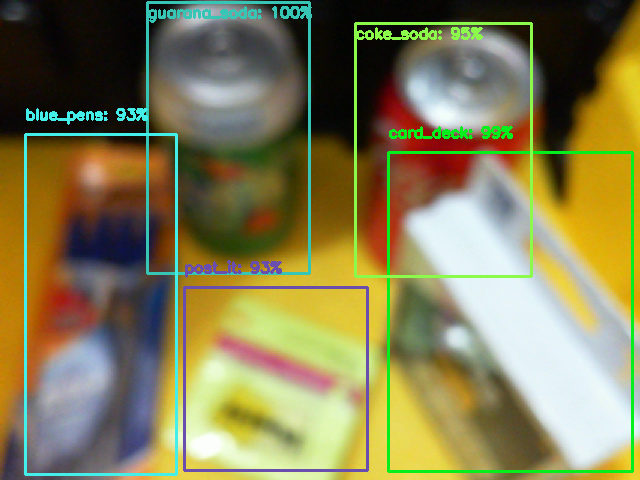

In [201]:
# Show the detection result
Image.fromarray(detection_result_image)